In [1]:
import pandas as pd
import numpy as np
from pgmpy.estimators import HillClimbSearch, K2Score
from pgmpy.models import BayesianModel
from pgmpy.inference import VariableElimination
from pgmpy.factors.discrete import DiscreteFactor
import networkx as nx
import pylab as plt

In [0]:
'''
Collab stuff

!mkdir dataset

!mv 15features.csv dataset/

!pip install pgmpy
!pip install 'matplotlib <= 2.2.3'

'''

In [2]:
data = pd.read_csv("../dataset/15features.csv")
data["imagename"] = data.imagename.str.split("[a-z]",expand=True)
for columns in data.columns:
    if(columns != "imagename"):
        data[str(columns)] = data[str(columns)] - 1
data.head()

,imagename,pen_pressure,letter_spacing,size,dimension,is_lowercase,is_continuous,slantness,tilt,entry_stroke_a,staff_of_a,formation_n,staff_of_d,exit_stroke_d,word_formation,constancy
0,0968,1,1,1,0,1,1,2,1,0,1,1,2,1,1,0
1,0809,1,1,1,1,1,1,2,0,0,1,1,2,0,1,1
2,0237,1,1,1,1,1,1,1,1,0,1,1,1,1,1,1
3,0069,1,1,1,0,1,1,0,0,0,0,0,0,0,0,0
4,0966,1,1,1,1,1,1,1,0,0,1,1,1,1,1,1


In [20]:
def genPositiveData(data):
    skeleton = pd.DataFrame()
    writers = np.unique(data.imagename)
    for writer in writers:
        query = str("imagename == '"+str(writer)+"'")
        test = data.query(str(query))
        data1 = test.sample(frac=1)
        data2 = test.sample(frac=1)
        data2 = data2.add_prefix('right_')
        temp = pd.concat([data1.reset_index(drop=True),data2.reset_index(drop=True)],axis=1)
        skeleton = skeleton.append(temp)
    return skeleton

def genNegativeData(data):
    data1 = data.sample(frac=1)
    data2 = data.sample(frac=1)
    data2 = data2.add_prefix('right_')
    negSamples = pd.concat([data1.reset_index(drop=True),data2.reset_index(drop=True)],axis=1)
    return negSamples

In [34]:
skeleton = pd.DataFrame()
posData = genPositiveData(data)
negData = genNegativeData(data)
temp = negData.append(posData).reset_index(drop=True)
skeleton = temp.append(skeleton)

bigBadDataset = skeleton
bigBadDataset["sameWriter"]=0
bigBadDataset.sameWriter  = np.where(bigBadDataset["imagename"] == bigBadDataset["right_imagename"],1,0)
bigBadDataset = bigBadDataset.drop(["imagename","right_imagename"],axis=1)
bigBadDataset = bigBadDataset.reset_index(drop=True)
trainData = bigBadDataset[0:int(np.floor(len(bigBadDataset)*0.8))]
testData = bigBadDataset[int(np.floor(len(bigBadDataset)*0.8)):]
trainData = trainData.reset_index(drop=True)
testData = testData.reset_index(drop=True)

In [0]:
'''
Takes More than 1 hour to train, but 74% accuracy
Approximately same amount of time to infer, but 74% accuracy !
Could be used for small datasets
'''
est = HillClimbSearch(trainData, scoring_method=K2Score(trainData))
%time ssj2Model = est.estimate(max_indegree=2)

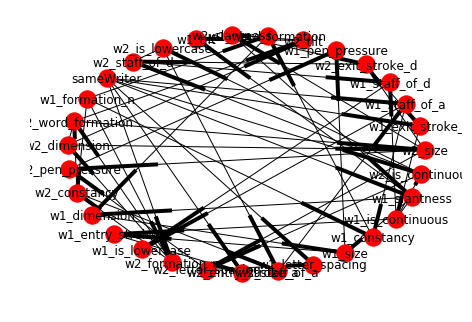

In [0]:
nx.draw(ssj2Model, with_labels=True)
plt.show()

In [0]:
ssj2Model.fit(trainData,complete_samples_only=True)

In [0]:
sameWriterPrediction = ssj2Model.predict(testData.iloc[:,0:30])

In [0]:
accuracy = 0
for row in range(len(sameWriterPrediction)):
    if sameWriterPrediction.sameWriter[row] == testData.sameWriter[row]:
        accuracy +=1

accuracy/len(testData)

1

In [0]:
accuracy/len(testData)

0.7406042741341193

In [0]:
from pgmpy.readwrite import BIFWriter

In [0]:
model_data = BIFWriter(ssj2Model)
model_data.write_bif(filename='ssj2Model.bif')

## Method 2

In [48]:
writers = data.imagename
rawData = data.iloc[:,1:]
rawData.head()

,pen_pressure,letter_spacing,size,dimension,is_lowercase,is_continuous,slantness,tilt,entry_stroke_a,staff_of_a,formation_n,staff_of_d,exit_stroke_d,word_formation,constancy
0,1,1,1,0,1,1,2,1,0,1,1,2,1,1,0
1,1,1,1,1,1,1,2,0,0,1,1,2,0,1,1
2,1,1,1,1,1,1,1,1,0,1,1,1,1,1,1
3,1,1,1,0,1,1,0,0,0,0,0,0,0,0,0
4,1,1,1,1,1,1,1,0,0,1,1,1,1,1,1


In [53]:
trainData = data[0:int(np.floor(len(data)*0.8))]
testData = data[int(np.floor(len(data)*0.8)):]

In [56]:
trainWriters = trainData.imagename
trainFeat = trainData.iloc[:,1:]
testWriters = testData.imagename
testFeat = testData.iloc[:,1:]

In [62]:
est = HillClimbSearch(trainFeat, scoring_method=K2Score(trainFeat))
%time revivalModel2 = est.estimate(max_indegree=1)

CPU times: user 2min 7s, sys: 355 ms, total: 2min 7s
Wall time: 2min 7s


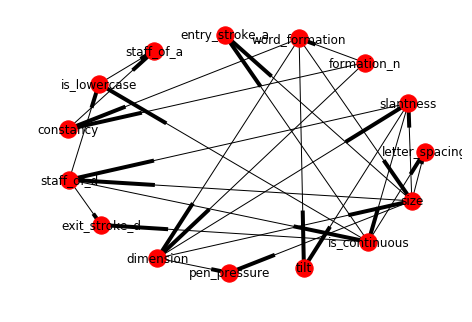

In [63]:
nx.draw(revivalModel2, with_labels=True)
plt.show()

In [64]:
skeleton = pd.DataFrame()
posData = genPositiveData(trainData)
negData = genNegativeData(trainData)
temp = negData.append(posData).reset_index(drop=True)
skeleton = temp.append(skeleton)
fitData = skeleton

fitData["sameWriter"]=0

fitData.sameWriter  = np.where(fitData["imagename"] == fitData["right_imagename"],1,0)

fitData = fitData.drop(["imagename","right_imagename"],axis=1)

fitData.head()

,pen_pressure,letter_spacing,size,dimension,is_lowercase,is_continuous,slantness,tilt,entry_stroke_a,staff_of_a,...,right_slantness,right_tilt,right_entry_stroke_a,right_staff_of_a,right_formation_n,right_staff_of_d,right_exit_stroke_d,right_word_formation,right_constancy,sameWriter
0,0,1,1,1,1,1,0,0,0,1,...,0,0,0,1,1,1,3,0,0,0
1,0,1,0,1,1,1,3,0,0,3,...,1,0,0,1,1,2,1,1,1,0
2,0,1,1,1,1,0,1,1,0,3,...,0,0,0,1,1,2,1,0,0,0
3,1,1,1,1,1,1,0,1,0,1,...,0,0,0,3,1,1,0,1,1,0
4,0,1,1,2,1,1,0,1,0,3,...,1,1,0,1,1,2,1,0,0,0


In [65]:
sampleData = pd.concat([fitData.iloc[:,0:15],fitData.iloc[:,30:]],axis=1)
corMat = sampleData.corr()

In [66]:
corMat

,pen_pressure,letter_spacing,size,dimension,is_lowercase,is_continuous,slantness,tilt,entry_stroke_a,staff_of_a,formation_n,staff_of_d,exit_stroke_d,word_formation,constancy,sameWriter
pen_pressure,1.000000,0.106177,-0.292600,-0.268930,0.089023,0.094350,0.091159,-0.021306,0.077505,-0.009443,-0.066882,0.106405,0.126797,-0.052554,-0.048472,-0.000101
letter_spacing,0.106177,1.000000,-0.054876,-0.058679,-0.028055,-0.144312,-0.037036,0.011638,-0.056640,0.030128,-0.004002,-0.040349,-0.006909,0.013566,0.010670,0.000239
size,-0.292600,-0.054876,1.000000,0.697290,-0.084501,-0.270406,-0.187906,-0.034764,-0.131876,0.093310,0.289305,-0.170534,-0.230027,0.284725,0.248738,-0.000014
dimension,-0.268930,-0.058679,0.697290,1.000000,-0.097695,-0.261012,-0.175646,-0.022047,-0.120768,0.093827,0.299005,-0.166107,-0.205456,0.285525,0.249083,-0.000454
is_lowercase,0.089023,-0.028055,-0.084501,-0.097695,1.000000,0.153445,0.044126,0.013589,0.030214,0.142480,-0.046740,0.192118,0.119440,-0.044212,-0.011119,0.000068
is_continuous,0.094350,-0.144312,-0.270406,-0.261012,0.153445,1.000000,0.106161,0.017629,0.135227,-0.043372,-0.208264,0.322790,0.298693,-0.175170,-0.138391,-0.000001
slantness,0.091159,-0.037036,-0.187906,-0.175646,0.044126,0.106161,1.000000,0.130933,0.060791,-0.038713,-0.059323,0.063130,0.045228,-0.087965,-0.038139,0.000163
tilt,-0.021306,0.011638,-0.034764,-0.022047,0.013589,0.017629,0.130933,1.000000,0.023032,-0.016590,-0.034588,0.005726,-0.015517,-0.063275,-0.047130,-0.000035
entry_stroke_a,0.077505,-0.056640,-0.131876,-0.120768,0.030214,0.135227,0.060791,0.023032,1.000000,-0.026244,-0.007559,0.016717,0.081101,-0.014331,0.008769,-0.000136
staff_of_a,-0.009443,0.030128,0.093310,0.093827,0.142480,-0.043372,-0.038713,-0.016590,-0.026244,1.000000,0.109774,0.027567,0.000541,0.108867,0.123311,0.000163


In [67]:
rightEdges = []
for x,y in revivalModel2.edges():
    x,y = str("right_"+x),str("right_"+y)
    temp = (x,y)
    rightEdges.append(temp)

In [68]:
right = BayesianModel()

In [69]:
for edge in rightEdges:
    revivalModel2.add_edge(edge[0],edge[1])

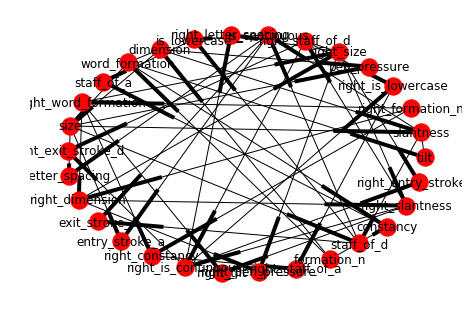

In [70]:
nx.draw(revivalModel2, with_labels=True)
plt.show()

In [71]:
augmenting_nodes = []
for x,y in revivalModel2.edges():
    if(x not in augmenting_nodes):
        augmenting_nodes.append(x)

In [72]:
augmented_edges = [('right_slantness','sameWriter'),
('right_exit_stroke_d','sameWriter'),
('dimension','sameWriter'),
('entry_stroke_a','sameWriter'),
('tilt','sameWriter'),
('right_is_continuous','sameWriter')]

In [73]:
for edge in augmented_edges:
    revivalModel2.add_edge(edge[0],edge[1])

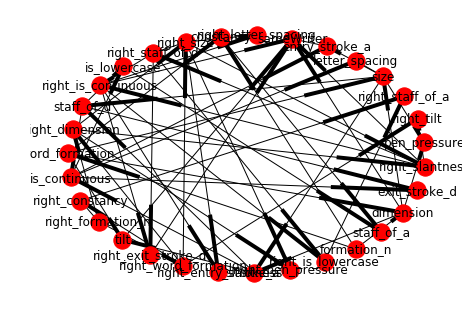

In [74]:
nx.draw(revivalModel2, with_labels=True)
plt.show()

## Train Time
### CPU times: user 1.3 s, sys: 0 ns, total: 1.3 s
### Wall time: 1.3 s


In [75]:
%time revivalModel2.fit(fitData)

CPU times: user 1.5 s, sys: 3.98 ms, total: 1.51 s
Wall time: 1.51 s


In [76]:
testData = pd.concat([testWriters, testFeat],axis = 1)

In [77]:
skeleton = pd.DataFrame()
posData = genPositiveData(testData)
negData = genNegativeData(testData)
temp = negData.append(posData).reset_index(drop=True)
skeleton = temp.append(skeleton)
testData = skeleton

testData["sameWriter"]=0

testData.sameWriter  = np.where(testData["imagename"] == testData["right_imagename"],1,0)

testData = testData.drop(["imagename","right_imagename"],axis=1)

testData.head()

,pen_pressure,letter_spacing,size,dimension,is_lowercase,is_continuous,slantness,tilt,entry_stroke_a,staff_of_a,...,right_slantness,right_tilt,right_entry_stroke_a,right_staff_of_a,right_formation_n,right_staff_of_d,right_exit_stroke_d,right_word_formation,right_constancy,sameWriter
0,0,2,2,2,1,0,0,0,0,1,...,0,0,0,1,1,1,1,0,0,0
1,0,1,1,1,1,1,2,0,0,3,...,0,0,0,0,0,1,1,0,0,0
2,0,0,2,2,1,1,2,0,0,1,...,0,0,0,1,1,1,3,1,1,0
3,1,2,1,1,1,1,1,1,0,1,...,0,1,0,0,1,0,0,0,1,0
4,0,0,0,0,1,1,0,1,0,0,...,1,0,0,1,1,1,2,0,1,0


In [78]:
inference = VariableElimination(revivalModel2)

In [79]:
%time pred_data = revivalModel2.predict(testData.iloc[:,0:30])

KeyboardInterrupt: 

In [117]:
acc = 0
for row in range(len(testData)):
    if(int(pred_data.iloc[row] == testData.sameWriter[row])):
        acc +=1
acc/len(testData)

0.5604274134119381

In [116]:
'''
Accuracy is around 56% for this method
Inference time is 22 Mins
'''

0.5604274134119381

# Method 3

In [21]:
skeleton = pd.DataFrame()
posData = genPositiveData(data)
negData = genNegativeData(data)
temp = negData.append(posData).reset_index(drop=True)
skeleton = temp.append(skeleton)

In [24]:
featureTransform = skeleton
featureTransform.head()

,imagename,pen_pressure,letter_spacing,size,dimension,is_lowercase,is_continuous,slantness,tilt,entry_stroke_a,...,right_is_continuous,right_slantness,right_tilt,right_entry_stroke_a,right_staff_of_a,right_formation_n,right_staff_of_d,right_exit_stroke_d,right_word_formation,right_constancy
0,1021,1,1,2,2,1,1,1,0,0,...,0,0,0,0,1,1,1,1,1,1
1,1560,1,1,2,2,1,0,0,0,0,...,0,0,0,0,1,1,1,0,1,1
2,1127,1,1,1,1,1,1,1,0,1,...,0,0,1,0,3,1,1,0,1,1
3,0409,0,1,1,1,1,1,3,1,0,...,1,0,0,1,1,1,1,2,1,1
4,1117,1,1,1,1,1,1,3,0,0,...,1,1,1,0,1,1,1,1,1,1


In [27]:
bigBadDataset = skeleton
bigBadDataset["sameWriter"]=0
bigBadDataset.sameWriter  = np.where(bigBadDataset["imagename"] == bigBadDataset["right_imagename"],1,0)
bigBadDataset = bigBadDataset.drop(["imagename","right_imagename"],axis=1)
bigBadDataset = bigBadDataset.sample(frac=1)
bigBadDataset = bigBadDataset.reset_index(drop=True)
bigBadDataset.head()

,pen_pressure,letter_spacing,size,dimension,is_lowercase,is_continuous,slantness,tilt,entry_stroke_a,staff_of_a,...,right_slantness,right_tilt,right_entry_stroke_a,right_staff_of_a,right_formation_n,right_staff_of_d,right_exit_stroke_d,right_word_formation,right_constancy,sameWriter
0,1,0,1,1,1,1,1,1,0,1,...,0,0,0,3,1,1,3,1,1,0
1,0,2,0,1,1,1,1,1,0,3,...,0,0,0,1,1,1,0,1,1,0
2,0,0,1,0,1,0,1,1,0,0,...,2,1,0,1,1,1,1,1,1,0
3,0,1,1,1,1,1,2,0,0,1,...,2,0,0,0,1,2,0,0,0,1
4,0,1,1,1,1,1,0,0,0,0,...,1,0,0,1,1,1,2,0,0,0


In [105]:
skeleton=pd.DataFrame()
for cols in bigBadDataset.columns[0:15]:
    skeleton[cols] = np.abs(bigBadDataset[cols] - bigBadDataset[str("right_"+cols)])

In [106]:
newFeatureDataset = pd.concat([skeleton,bigBadDataset.iloc[:,30:]],axis=1)

In [93]:
trainData = newFeatureDataset[0:int(np.floor(len(newFeatureDataset)*0.8))]
testData = newFeatureDataset[int(np.floor(len(newFeatureDataset)*0.8)):]
testData = testData.sample(frac=1).reset_index(drop=True)

In [86]:
est = HillClimbSearch(trainData, scoring_method=K2Score(trainData))
%time revivalModel2 = est.estimate(max_indegree=2)

CPU times: user 3min 39s, sys: 194 ms, total: 3min 39s
Wall time: 3min 39s


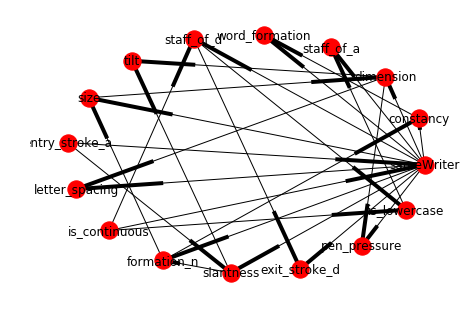

In [132]:
nx.draw(revivalModel2, with_labels=True)
plt.show()

In [125]:
%time revivalModel2.fit(trainData)

CPU times: user 472 ms, sys: 3.93 ms, total: 476 ms
Wall time: 473 ms


In [126]:
%time sameWriterPrediction = revivalModel2.predict(testData.iloc[:,0:15])

CPU times: user 5min 26s, sys: 1.96 s, total: 5min 28s
Wall time: 5min 26s


In [128]:
acc = 0
for row in range(len(testData)):
    if(int(sameWriterPrediction.iloc[row] == testData.sameWriter[row])):
        acc +=1
acc/len(testData)

0.7708179808400885

In [140]:
bestModel= pd.DataFrame({'Accuracy': "77%", "Number of Edges":"28", "Time to Train":"476 ms","Time to Infer":"5min 28s"},index=[0])

In [141]:
bestModel

,Accuracy,Number of Edges,Time to Train,Time to Infer
0,77%,28,476 ms,5min 28s
